# MRMS and ERA5 domain info

In [1]:
import sys
import time
import h5py
import pygrib
import numpy as np
import netCDF4 as nc
from datetime import datetime, timedelta

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

In [4]:
from scipy.spatial import cKDTree

In [5]:
# with nc.Dataset(ERA5_dir+'ERA5_APCP_2018_2023.nc') as ncio:
#     era5_x = np.array(ncio['longitude'][...])
#     era5_y = np.array(ncio['latitude'][...])
# #     #apcp = ncio['tp'][18000, 1, :, :]

In [6]:
# lon_25, lat_25 = np.meshgrid(era5_x, era5_y)

In [7]:
# with pygrib.open(MRMS_dir+'MRMS_MultiSensor_QPE_01H_Pass2_00.00_20210101-210000.grib2') as grbio:
#     #MRMS = grbio[1].values
#     lat, lon = grbio[1].latlons()
# lon = lon-360

In [8]:
# tuple_save = (lon_25, lat_25, lon, lat)
# label_save = ['lon_ERA5', 'lat_ERA5', 'lon_MRMS', 'lat_MRMS']

# du.save_hdf5(tuple_save, label_save, save_dir, 'MRMS_ERA5_domain.hdf')

In [16]:
with h5py.File(save_dir+'MRMS_ERA5_domain.hdf', 'r') as h5io:
    lon_ERA5 = h5io['lon_ERA5'][...]
    lat_ERA5 = h5io['lat_ERA5'][...]
    lon_MRMS = h5io['lon_MRMS'][...]
    lat_MRMS = h5io['lat_MRMS'][...]
    elev_MRMS = h5io['elev_MRMS'][...]
    land_mask_MRMS = h5io['land_mask_MRMS'][...]

    indx_array = h5io['MRMS_to_ERA5_indx'][...]
    indy_array = h5io['MRMS_to_ERA5_indy'][...]
    
    # indx = h5io['MRMS_to_ERA5_indx'][...]
    # indy = h5io['MRMS_to_ERA5_indy'][...]

In [17]:
lat_ERA5 = np.flipud(lat_ERA5)
lat_MRMS = np.flipud(lat_MRMS)

In [18]:
indx_array = np.flipud(indx_array)
indy_array = np.flipud(indy_array)

In [12]:
# x_32 = np.arange(np.min(lon_ERA5), np.max(lon_ERA5), 0.32)
# y_32 = np.arange(np.min(lat_ERA5), np.max(lat_ERA5), 0.32)
# lon_32, lat_32 = np.meshgrid(x_32, y_32)

In [13]:
shape_MRMS = lon_MRMS.shape
shape_ERA5 = lon_ERA5.shape

indx_array = np.empty(shape_MRMS)
indy_array = np.empty(shape_MRMS)

gridTree = cKDTree(list(zip(lon_ERA5.ravel(), lat_ERA5.ravel())))

for xi in range(shape_MRMS[0]):
    for yi in range(shape_MRMS[1]):
        
        temp_lon = lon_MRMS[xi, yi]
        temp_lat = lat_MRMS[xi, yi]
        
        _, indexes = gridTree.query(list(zip(np.array(temp_lon)[None], np.array(temp_lat)[None])))
        indx_in_ERA5, indy_in_ERA5 = np.unravel_index(indexes, shape_ERA5)
        
        indx_array[xi, yi] = indx_in_ERA5[0]
        indy_array[xi, yi] = indy_in_ERA5[0]


KeyboardInterrupt



In [20]:
i = 350
j = 450

print('{} vs. {}'.format(lon_MRMS[i, j], lon_ERA5[int(indx_array[i, j]), int(indy_array[i, j])]))

-125.49500012859244 vs. -125.5


In [14]:
# tuple_save = (lon_ERA5, lat_ERA5, lon_MRMS, lat_MRMS, indx_array, indy_array)
# label_save = ['lon_ERA5', 'lat_ERA5', 'lon_MRMS', 'lat_MRMS', 'MRMR_to_ERA5_indx', 'MRMR_to_ERA5_indy']

# du.save_hdf5(tuple_save, label_save, save_dir, 'MRMS_ERA5_domain.hdf')

**Land mask prepration**

In [15]:
from scipy.interpolate import griddata

import scipy.interpolate as spint
#from scipy.spatial.qhull import Delaunay
from scipy.spatial import Delaunay
import itertools

In [16]:
def interp_weights(xy, uv, d=2):
    tri = Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

In [31]:
with nc.Dataset('/glade/campaign/cisl/aiml/ksha/BACKUP/ETOPO1_Ice_g_gmt4.grd', 'r') as ncio:
    x = ncio['x'][2500:7400]
    y = ncio['y'][6500:9000]
    z = ncio['z'][6500:9000, 2500:7400]

long, lat = np.meshgrid(x, y)
long = np.array(long)
lat = np.array(lat)

In [ ]:
#Computed once and for all !
vtx, wts = interp_weights(np.vstack([long.ravel(), lat.ravel()]).T, np.vstack([lon_MRMS.ravel(), lat_MRMS.ravel()]).T)

In [ ]:
# start_time = time.time()
# land_mask_MRMS_temp = interpolate(land_mask_3km.ravel(), vtx, wts)
# land_mask_MRMS_temp = land_mask_MRMS_temp.reshape(lon_MRMS.shape)
# print("--- %s seconds ---" % (time.time() - start_time))

# land_mask_MRMS = np.copy(land_mask_MRMS_temp)
# land_mask_MRMS[np.isnan(land_mask_MRMS)] = 0.0
# land_mask_MRMS[land_mask_MRMS>0.5] = 1.0

In [ ]:
start_time = time.time()
elev_MRMS_temp = interpolate(z.ravel(), vtx, wts)
elev_MRMS_temp = elev_MRMS_temp.reshape(lon_MRMS.shape)
print("--- %s seconds ---" % (time.time() - start_time))

elev_MRMS = np.copy(elev_MRMS_temp)

In [ ]:
np.max(elev_MRMS)

In [ ]:
elev_MRMS[np.isnan(elev_MRMS)] = 0.0
elev_MRMS[elev_MRMS<0] = 0.0

In [6]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

# cmap_pct, A = gu.precip_cmap()

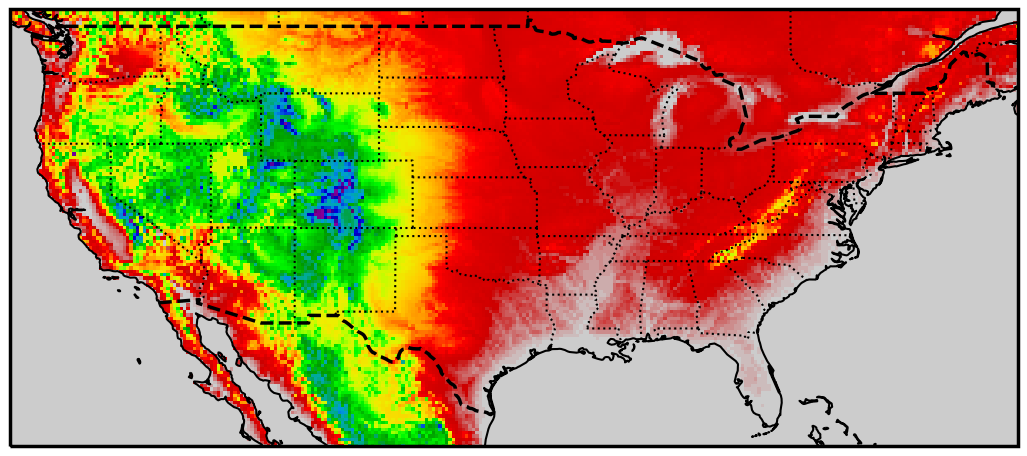

In [7]:
edge_ = [-126, -66, 24, 50]
proj_ = projection=ccrs.PlateCarree() # ccrs.NorthPolarStereo(central_longitude=-98.75)

fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj_)

ax.set_extent(edge_, ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5)
ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5)
ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5)    
ax.spines['geo'].set_linewidth(2.5)

ax.pcolormesh(lon_MRMS[::20, ::20], lat_MRMS[::20, ::20], elev_MRMS[::20, ::20], cmap=plt.cm.nipy_spectral_r, vmin=0, vmax=4000);

In [21]:
tuple_save = (lon_ERA5, lat_ERA5, lon_MRMS, lat_MRMS, indx_array, indy_array, land_mask_MRMS, elev_MRMS)
label_save = ['lon_ERA5', 'lat_ERA5', 'lon_MRMS', 'lat_MRMS', 'MRMS_to_ERA5_indx', 'MRMS_to_ERA5_indy', 'land_mask_MRMS', 'elev_MRMS']

du.save_hdf5(tuple_save, label_save, save_dir, 'MRMS_ERA5_domain.hdf')

Save to /glade/work/ksha/GAN/MRMS_ERA5_domain.hdf
